In [76]:
import numpy as np
from tqdm import tqdm
import numpy as np
import pandas as pd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.svm import SVC
from SVM import OVO_test, OVO_train
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def rgb2gray(x):
    #last axis of x must be the number of axis
    return x@[0.2125, 0.7154, 0.0721]



def extract_patch(image, patch_size):
    corner = np.random.randint(32 - patch_size, size=2)
    i,j = corner[0], corner[1]
    patch = image[i:i+patch_size, j:j+patch_size, :]
    patch = patch - np.mean(patch)

    patch/=(np.std(patch)+0.01)
    return patch


def extract_patches(dataset, num_patches, patch_size):
    n_images = len(dataset)
    num_patches_per_image = num_patches//n_images
    patches = np.zeros((n_images, num_patches_per_image, patch_size, patch_size, 3))
    for i in tqdm(range(n_images)):
        for j in range(num_patches_per_image):
            patch = extract_patch(dataset[i], patch_size)
            patches[i, j] = patch
    return patches

def cluster_patches(patches, k):
    n = len(patches)
    data = patches.reshape(n,-1)
    clust = KMeans(n_clusters=k)
    clust.fit(data)
    return clust.labels_, clust.cluster_centers_

def whiten_patches(patches):
    """ whiten """
    feats = patches.reshape(len(patches), -1)
    C = np.cov(feats, rowvar=False)  # 108 x 108 (for 6x6x3 kernels)
    M = np.mean(feats, axis=0)
    d, V = np.linalg.eigh(C)
    D = np.diag(np.sqrt(1. / (d + 0.1)))
    P = np.matmul(np.matmul(V, D), V.T)
    feats = np.matmul(feats - M, P)

    return feats, M, P 

def get_quarters(img):
    img_size = img.shape[0]
    half_size = img_size//2
    q1 = img[:half_size, :half_size,:]
    q2 = img[half_size:, :half_size,:]
    q3 = img[:half_size, half_size:,:]
    q4 = img[half_size:, half_size:,:]
    return [q1, q2, q3, q4]

def compute_features_patch(patch, centroids):
    k = len(centroids)
    z = np.zeros(k)
    for i, centroid in enumerate(centroids):
        z[i] = np.linalg.norm(patch.reshape(-1) - centroid)
    f =  np.maximum(np.zeros(k), np.mean(z)*np.ones(k) - z)
    return f

def compute_features_img(img, centroids, stride, patch_size):
    k = len(centroids)
    img_feat = np.zeros(k)
    img_size = img.shape[0]
    i = 0
    while i+patch_size < img_size:
        j = 0
        while j+patch_size < img_size:
            patch = img[i:i+patch_size, j:j+patch_size,:]
            j+=stride
            f = compute_features_patch(patch, centroids)
            img_feat += f
            #print(i,j)
        i+=stride
    return img_feat

def compute_features(dataset, centroids, stride, patch_size):
    X = []    
    for img in tqdm(dataset):
        quart = get_quarters(img)
        f = []
        for i in range(4):
            quarter_feats = compute_features_img(quart[i], centroids, stride, patch_size)
            #shape num_patches_in_quarter x k
            f.append(quarter_feats) #only k features per quarter
        #print(f.shape)
        X.append(f)
    X = np.array(X)
    X = X.reshape(len(X), -1)
    X -= X.mean(axis=0, keepdims=True)
    X /= (0.01 + np.std(X, axis=0))
    return X

def plot_image(image, ax):
    im = np.zeros_like(image)
    for i in range(3):
        channel_min = np.min(image[:,:,i], keepdims=True)
        channel_max = np.max(image[:,:,i], keepdims=True)
        im[:,:,i] = (image[:,:,i] - channel_min) / (channel_max - channel_min)
    ax.imshow(im)




In [24]:
Xtr = pd.read_csv('data/Xtr.csv',header=None,sep=',',usecols=range(3072))
Xte = pd.read_csv('data/Xte.csv',header=None,sep=',',usecols=range(3072))
Ytr_ = pd.read_csv('data/Ytr.csv')#, index_col = None, header = None)

In [25]:
Xtr = np.array(Xtr).reshape(5000, 3,32, 32).swapaxes(1,2).swapaxes(2,3)
Xte = np.array(Xte).reshape(2000, 3,32, 32).swapaxes(1,2).swapaxes(2,3)
Ytr = np.array(Ytr_['Prediction'])

#Xtr_ = rgb2gray(Xtr)
#Xte_ = rgb2gray(Xte)

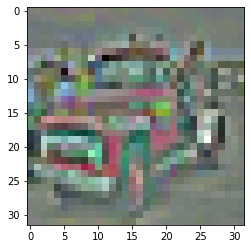

In [26]:
fig, ax = plt.subplots()
plot_image(Xtr[6], ax)

# Feature learning

In [5]:
test = extract_patches(Xtr[:1], num_patches = 50, patch_size=6)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 306.56it/s]


In [27]:
patches = extract_patches(Xtr, 200000, 6)

100%|██████████████████████████████████████| 5000/5000 [00:09<00:00, 550.15it/s]


In [30]:
patches = patches.reshape(-1, 6, 6, 3)

In [31]:
labels, centroids = cluster_patches(patches, 400)

In [32]:
centroids.shape

(400, 108)

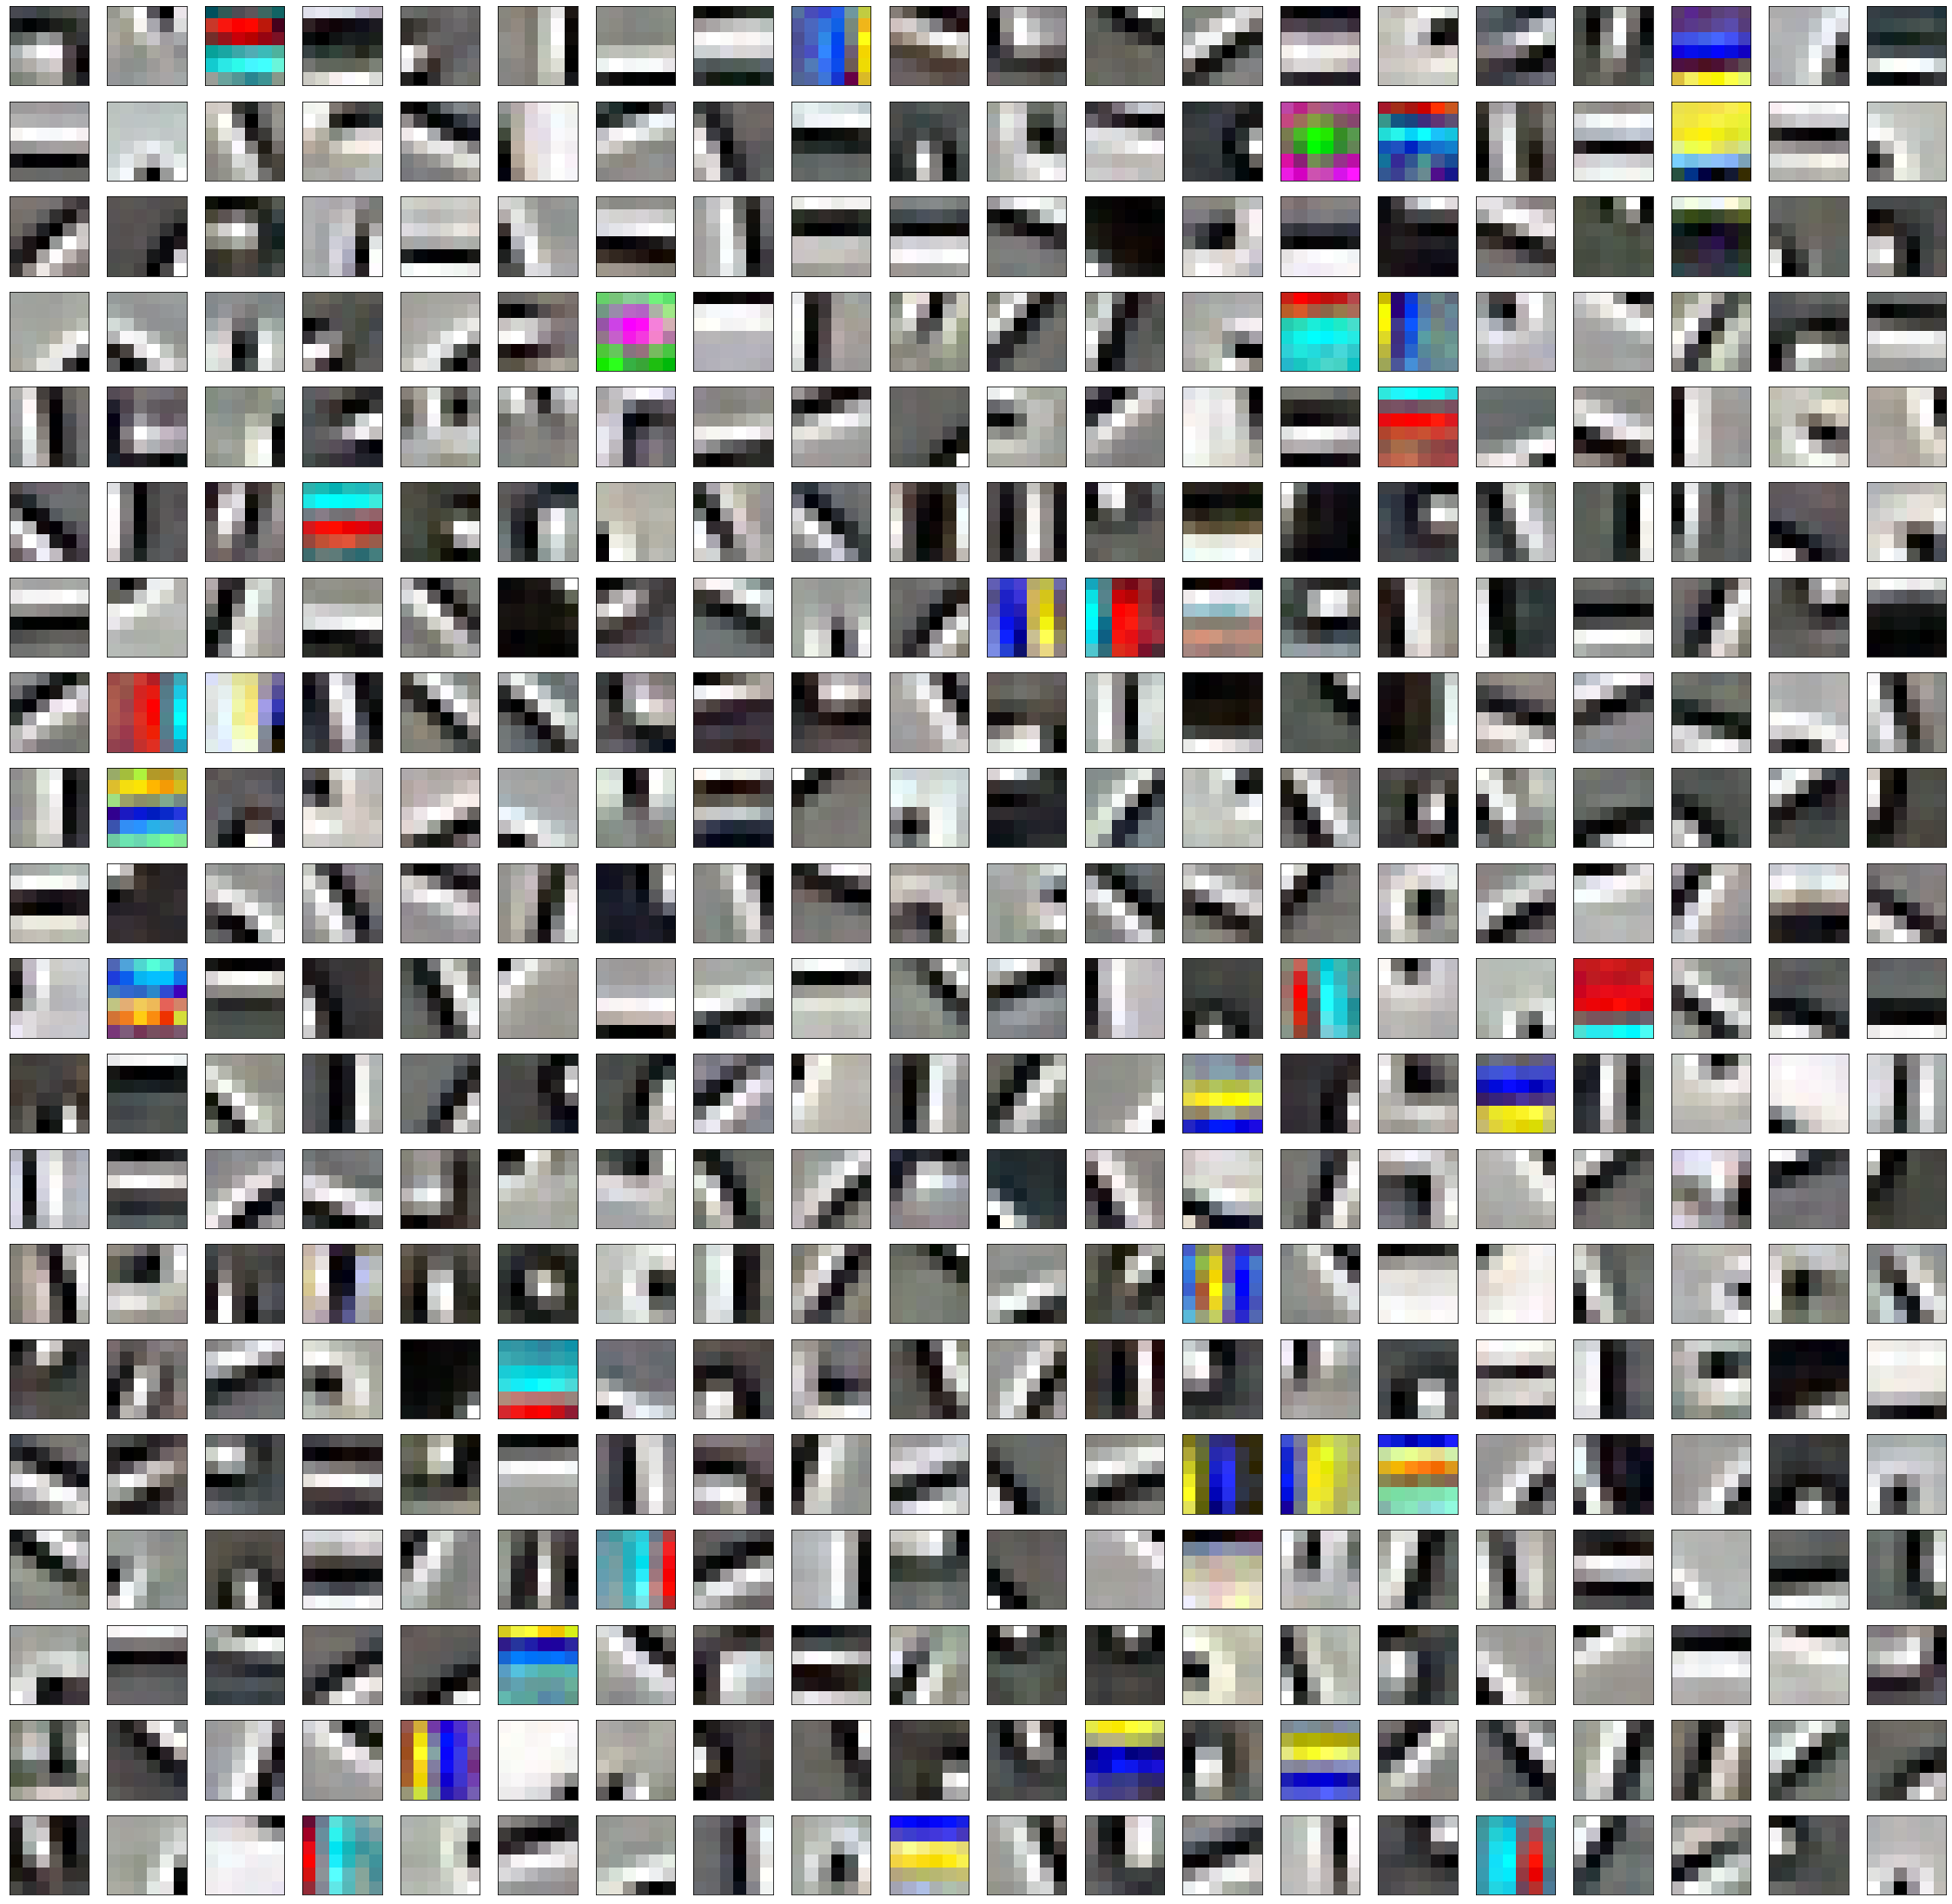

In [33]:
fig, ax = plt.subplots(20,20, figsize = (40,40))
idx = 0
for i in range(20):
    for j in range(20):
        plot_image(centroids[idx].reshape(6, 6, 3), ax[i,j])
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
        idx+=1

# Feature extraction

In [34]:
#dataset = Xtr_
#dataset.shape
X_train = compute_features(Xtr, centroids, stride=2, patch_size=6)
X_test = compute_features(Xte, centroids, stride=2, patch_size=6)

100%|███████████████████████████████████████| 2000/2000 [07:09<00:00,  4.65it/s]


In [36]:
np.save('X_train', X_train)
np.save('X_test', X_test)

X_train = np.load('X_train.npy')
X_test= np.load('X_test.npy')

In [77]:
X_train /= (0.01 + np.std(X_train, axis=0))
X_test /= (0.01 + np.std(X_test, axis=0))


X_tr, X_te, y_tr, y_te = train_test_split(X_train, Ytr, test_size=0.33, random_state=42)

In [90]:
classifier = SVC(C=20, decision_function_shape='ovo')
classifier.fit(X_tr, y_tr)

SVC(C=20, decision_function_shape='ovo')

In [91]:
pred = classifier.predict(X_te)

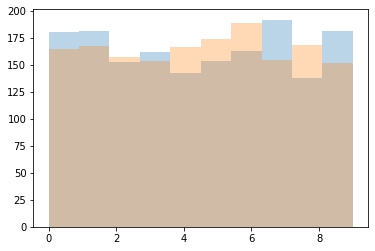

In [92]:
plt.hist(pred, alpha=0.3)
plt.hist(y_te, alpha=0.3)
plt.show()

In [93]:
accuracy_score(pred, y_te)

0.3993939393939394